In [1]:
import torch
import numpy as np
from model import make_model
from tools import Batch,CrossEntropyLossWithLabelSmoothing,get_std_opt,LossComputeAndStep,run_epoch,greedy_decode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#为了支持多模态，允许有多个输入，但目前没有多模态的需求，默认列表中只有一条序列或者有一些等长的序列
#生成器的输入序列与输出序列类型完全一样，不支持多模态！
#为了简便，默认0为填充，1为起始标记，剩余的为正常词汇，<UNK>、<END>算作正常词汇，可以在处理数据时自由定义
#生成任务与翻译任务需要在输入序列中手动添加起始标记，使得模型能够输出更长的序列
vocab_size = 12
input_vocab_sizes = [vocab_size]
output_vocab_size = vocab_size
setting = {
    #平衡资源消耗与效果
    "enable_affine" : True,                   #加快训练速度(epoch少)，几乎不影响速度，可能影响稳定性
    "enable_layer_norm" : True,               #增强模型稳定性，略微减慢速度
    "enable_talking_head" : False,             #增强模型表达能力，严重减慢速度，消耗显存
    "enable_gated_linear_unit_in_projector" : False,  #增强模型表达能力，输出词表很小时可用，规律十分明显的时候不要用
    "self_attention_block_size" : 0,          #自注意力运算时的分块大小，可以显著降低显存消耗，提供额外的位置信息，但速度较慢
    "head_number" : 8,    #启用talking_head时数量越多效果越好，但平方消耗，否则避免过大导致key_dim过小
    "glu_projector_multivalue" : 64,          #enable_gated...启用后生效，平方复杂度
    "glu_projector_deep" : 1,                 #enable_gated...启用后生效，实验用，不建议设置更大的数值
    #模型类型选择
    "model_type" : "translator",              #经典编码器-解码器架构，适合机器翻译
    # "model_type" : "classifier",              #分类器，没有解码器，编码完总结到固定长度进行分类
    # "model_type" : "generator",               #生成器，不停的预测下一个词，可以做大模型
    # "model_type" : "vit",                     #简单的图像分类 
    "share_embeddings" : False,             #是否进行词表共享，只对"translator"有效
    "summarizer_length" : 4,                #分类器的总结长度，总结时没法分块，注意资源消耗
    "patch_size" : 16,                      #图像分块的大小，只对vit有效
    "cross_attention_block_size" : 0, #在显存不足的时候对query分段计算cross_attention，会减慢速度，逻辑上与不分块一样，只有"translator"可用
    #参数规模设置
    "embedding_dim" : 64,                   #词嵌入维度
    "key_dim" : 64,                         #解决低秩问题
    "vocab_in_size_list" : input_vocab_sizes,  #输入词表大小，支持多个输入列表，可以多模态
    "vocab_out_size" : output_vocab_size,      #输出词表大小，共享词表时不支持多模态
    "feed_forward_dim" : 256,               #注意力运算结束后用于混合不同head信息的前馈网络隐藏层维度
    "model_layers_number" : 2,              #模型的层数，注意资源消耗
    #位置信息添加方式选择
    "position_information_type" : "mask_position_information",      #掩码位置信息，如果能训练好的话可以无限外推，但可能训练有困难
    # "position_information_type" : "no_position_information",        #没有位置信息（分类器可能会用）
    # "position_information_type" : "sinusoidal_position_encoding",   #余弦位置编码（经典，高效）
    # "position_information_type" : "rotary_position_encoding",       #旋转位置编码（更好的表达相对位置）
    # "position_information_type" : "rotary_position_encoding_with_random_start", #只使用相对信息，建议用掩码
    #增加泛化能力
    "dropout_rate" : 0.1 #训练时，注意力，前馈，talking都会随机丢弃计算结果，增加泛化能力
}
model1 = make_model(setting).to(device)
model1.load_state_dict(torch.load('inv_64.weight'))
setting["position_information_type"] = "sinusoidal_position_encoding" 
model2 = make_model(setting).to(device)
model2.load_state_dict(torch.load('sin_inv_64.weight'))
setting["position_information_type"] = "rotary_position_encoding" 
model3 = make_model(setting).to(device)
model3.load_state_dict(torch.load('rot_inv_64.weight'))

<All keys matched successfully>

In [3]:
#数据生成器
def data_generator(batch_per_epoch,batch_size,sequence_length):
    for i in range(batch_per_epoch):
        #0 代表填充、1 代表起始、2~vocab_length-1 代表正常词汇，有vocab_length-2个，np.random.randint取不到第二个参数
        np_data = np.random.randint(2,vocab_size,size=(batch_size,sequence_length+1))
        np_data[...,0] = 1
        input_sequence = torch.from_numpy(np_data[...,1:]).to(device)
        input_sequences = [input_sequence]
        np_data[...,1:] = np_data[...,1:][...,::-1]
        target_sequences = torch.from_numpy(np_data).to(device)
        yield Batch(input_sequences,target_sequences)

In [4]:
model = model1
model.eval()
acc1 = []
length1 = []
for sequence_length in range(4,128+1,4):
    length1 += [sequence_length]
    print("\r",sequence_length,end=" "*5)
    batch_size = 1000
    with torch.no_grad():
        #0 代表填充、1 代表起始、2~vocab_length-1 代表正常词汇，有vocab_length-2个，np.random.randint取不到第二个参数
        check_data = np.random.randint(2,vocab_size,size=(batch_size,sequence_length+1))
        check_data[...,0] = 1
        input_sequence = torch.from_numpy(check_data[...,1:]).to(device)
        input_sequences = [input_sequence]
        result = greedy_decode(model,input_sequences,out_length=sequence_length)
        check_data[...,1:] = check_data[...,1:][...,::-1]
        answer = torch.from_numpy(check_data[...,1:]).to(device)
        acc1 += [(result==answer).sum().data.cpu().numpy()/sequence_length/batch_size]

 128     

In [5]:
model = model2
model.eval()
acc2 = []
length2 = []
for sequence_length in range(4,128+1,4):
    length2 += [sequence_length]
    print("\r",sequence_length,end=" "*5)
    batch_size = 1000
    with torch.no_grad():
        #0 代表填充、1 代表起始、2~vocab_length-1 代表正常词汇，有vocab_length-2个，np.random.randint取不到第二个参数
        check_data = np.random.randint(2,vocab_size,size=(batch_size,sequence_length+1))
        check_data[...,0] = 1
        input_sequence = torch.from_numpy(check_data[...,1:]).to(device)
        input_sequences = [input_sequence]
        result = greedy_decode(model,input_sequences,out_length=sequence_length)
        check_data[...,1:] = check_data[...,1:][...,::-1]
        answer = torch.from_numpy(check_data[...,1:]).to(device)
        acc2 += [(result==answer).sum().data.cpu().numpy()/sequence_length/batch_size]

 128     

In [6]:
model = model3
model.eval()
acc3 = []
length3 = []
for sequence_length in range(4,128+1,4):
    length3 += [sequence_length]
    print("\r",sequence_length,end=" "*5)
    batch_size = 1000
    with torch.no_grad():
        #0 代表填充、1 代表起始、2~vocab_length-1 代表正常词汇，有vocab_length-2个，np.random.randint取不到第二个参数
        check_data = np.random.randint(2,vocab_size,size=(batch_size,sequence_length+1))
        check_data[...,0] = 1
        input_sequence = torch.from_numpy(check_data[...,1:]).to(device)
        input_sequences = [input_sequence]
        result = greedy_decode(model,input_sequences,out_length=sequence_length)
        check_data[...,1:] = check_data[...,1:][...,::-1]
        answer = torch.from_numpy(check_data[...,1:]).to(device)
        acc3 += [(result==answer).sum().data.cpu().numpy()/sequence_length/batch_size]

 128     

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

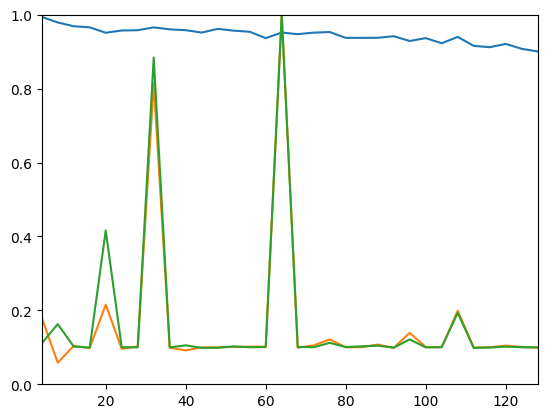

In [8]:
plt.ylim(0,1)
plt.xlim(4,128)
plt.plot(length1,acc1)
plt.plot(length2,acc2)
plt.plot(length3,acc3)
plt.show()

In [9]:
# for l,a in zip(length1,acc1):
#     print(l,a)

In [10]:
# for l,a in zip(length2,acc2):
#     print(l,a)

In [11]:
np.save('masked.npy',[length1,acc1])
np.save('sin.npy',[length2,acc2])
np.save('rot.npy',[length3,acc3])